## Authors:

Daniel Vila de la Cruz

Sara Gómez Feás

# Introduction

The forecasting of energy consumption has become very important for energy providers. Predicting energy consumption allows providers to plan and optimize their resources, avoiding blackouts or brownouts, and improving the reliability and affordability of energy services.

The goal of this problem is to predict the energy consumption for each hour based on historical data. This information could be used by an energy provider to act accordingly.

This problem falls under the regression category since the target variable, energy consumption, is a continuous numerical variable. We will first use batch learning methods and then compare them with the stream learning approach.

The chosen dataset is called Hourly Energy Consumption (https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption?select=AEP_hourly.csv), which contains over 10 years of hourly energy consumption readings from PJM, a regional transmission organization in the United States. There are several companies involved in the organization, but we are going to focus on AEP, which contains 121273 entries. The dataset contains two main features: a datetime indicating the energy reading time, with a precision of hours, and the power consumed in megawatts. The datetime feature is a time-series feature, which is essential for forecasting problems, while the power consumed feature is the target variable.

In [ ]:
# First let's import the libraries we need for this project
import river
from rich import print
from river import linear_model as river_linear_model
from river import stream
from river import metrics as river_metrics
from river import neighbors
from river import stats
from river import evaluate
from river import drift
from river.preprocessing import StandardScaler
from river import compose
from river import linear_model
from river import preprocessing as river_preprocessing
from river import tree
from river.compose import Pipeline
from river.compat import convert_river_to_sklearn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn import linear_model
from sklearn import metrics
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor


from rich import print
import random
import csv
import datetime
from datetime import date, datetime
import pandas as pd
import seaborn as sns
import os
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('ggplot')

# 1. Data preprocessing

First, let's load the dataset and see what information it contains and how the data is distributed.

In [ ]:
df = pd.read_parquet('dataset/est_hourly.paruqet')
df['datetime'] = pd.to_datetime(df.index)

In the original dataset, dates are sorted inconsistently, following an ascending order for year and hour, and descending for month and day. So the first step is to sort properly the data.

In [ ]:
df = df.sort_values('Datetime').reset_index(drop=True)

In [ ]:
# Description of the dataset
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


The histogram below shows how the target distribution is almost symmetric and centered around a single value, so the data is balanced.


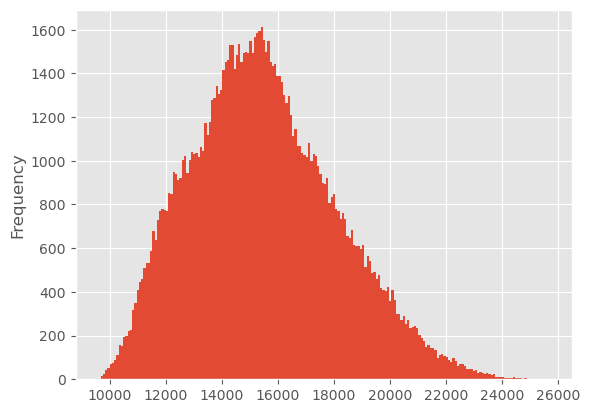

In [ ]:
_ = df['AEP'].plot.hist(bins=200)

If we take a look at the data, we see that each sample consists of a DateTime and the corresponding energy consumption. To address the problem that we have presented, the prediction of hourly energy consumption for the AEP company, we must first create new features.

First of all, we want to extract the year, month, day and time of consumption independently.

In [ ]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour

Due to the cyclical nature of these data, we have considered the sine and cosine of the hour, the day, and the month. This represents the fact that after December it comes January again or the fact that after the last hour of the day the clock "resets" and returns to the first hour <a id='hour_dist'></a>.

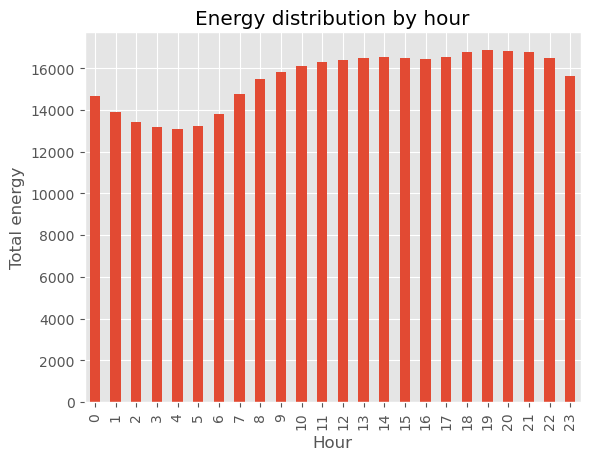

In [ ]:
energy_by_hour = df.groupby('hour')['AEP'].mean()

# plot the energy distribution across hours
energy_by_hour.plot(kind='bar')
plt.title('Energy distribution by hour')
plt.xlabel('Hour')
plt.ylabel('Total energy')
plt.show()

Therefore, we have 6 new features.

In [ ]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_sin'] = np.sin(2 * np.pi * df['day'] / df['datetime'].dt.days_in_month)

df['day_cos'] = np.cos(2 * np.pi * df['day'] / df['datetime'].dt.days_in_month)

# Check if the year is a leap year
if (df['datetime'].dt.is_leap_year.any()):
    dYear = 365
else:
    dYear = 366

# Convert the month component to radians, scaled by the number of days
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12 * df['datetime'].dt.days_in_month / dYear)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12 * df['datetime'].dt.days_in_month / dYear)

Analyzing the data, it has been seen that there are changes in energy consumption depending on whether or not it is a weekend. In addition, there is also the fact that depending on the time of year (summer, winter, spring...) consumption increases or decreases with the needs of the season. Seeing this, three other new features have been created: 'is_weekend', a boolean variable with value 0 if it is not a weekend and 1 otherwise, 'day_of_week', a categorical variable that takes values between 1 and 7 representing if it is Monday, Tuesday, Wednesday, etc., and 'season', a categorical variable that takes values ​​between 1 and 4 according to the following classification:  1 - winter, 2 - spring, 3 - summer, 4 - autumn.


In [ ]:
seasons = []

month = df['month']
day = df['day']

def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

def get_seasons(now):
    seasons = []
    for s in now:
        seasons.append(get_season(s))

    return seasons

Y = 2000

# 1: winter; 2: spring; 3: summer; 4: autumn
seasons = [(1, (date(Y,  1,  1),  date(Y,  3, 20))),
           (2, (date(Y,  3, 21),  date(Y,  6, 20))),
           (3, (date(Y,  6, 21),  date(Y,  9, 22))),
           (4, (date(Y,  9, 23),  date(Y, 12, 20))),
           (1, (date(Y, 12, 21),  date(Y, 12, 31)))]


df['season'] = get_seasons(df['datetime'].dt.date)
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

df['day_of_week'] = df['date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

df.pop('date')
aux = df.pop('datetime')
df[df.abs() < 1e-15] = 0.0
df['datetime'] = aux

On this graph we can see how during the week, the energy peak starts at 7am, and that during the weekends there is a lower energy consumption.

C:\Users\sarag\AppData\Local\Temp\ipykernel_24528\278418933.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  energy_matrix = energy_by_day_and_hour.pivot('day_of_week', 'hour', 'AEP')


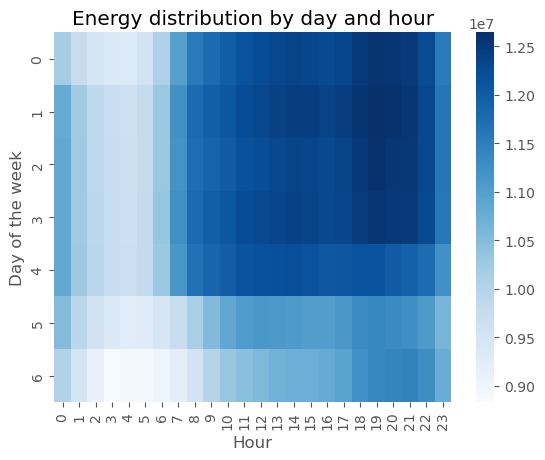

In [ ]:
energy_by_day_and_hour = df.groupby(['day_of_week', 'hour'])['AEP'].sum().reset_index()

# pivot the data to create a matrix with days of the week as rows and hours as columns
energy_matrix = energy_by_day_and_hour.pivot('day_of_week', 'hour', 'AEP')

# create a heatmap of the energy distribution across days of the week and hours
sns.heatmap(energy_matrix, cmap='Blues')
plt.title('Energy distribution by day and hour')
plt.xlabel('Hour')
plt.ylabel('Day of the week')
plt.show()

In [ ]:
# Drop other companies
df.pop('COMED')
df.pop('DAYTON')
df.pop('DEOK')
df.pop('DOM')
df.pop('DUQ')
df.pop('EKPC')
df.pop('FE')
df.pop('NI')
df.pop('PJME')
df.pop('PJMW')
df.pop('PJM_Load')

# Drop uncoded features
# df.pop('month')
# df.pop('day')
# df.pop('hour')

# datetime = df.pop('datetime')

df.dropna(inplace=True)
df

,AEP,year,month,day,hour,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,season,day_of_week,is_weekend,datetime
56987,12379.0,2004,10,1,1,0.258819,0.965926,0.201299,0.979530,0.430187,0.902740,4,4,0,2004-10-01 01:00:00
56988,11935.0,2004,10,1,2,0.500000,0.866025,0.201299,0.979530,0.430187,0.902740,4,4,0,2004-10-01 02:00:00
56989,11692.0,2004,10,1,3,0.707107,0.707107,0.201299,0.979530,0.430187,0.902740,4,4,0,2004-10-01 03:00:00
56990,11597.0,2004,10,1,4,0.866025,0.500000,0.201299,0.979530,0.430187,0.902740,4,4,0,2004-10-01 04:00:00
56991,11681.0,2004,10,1,5,0.965926,0.258819,0.201299,0.979530,0.430187,0.902740,4,4,0,2004-10-01 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178257,17673.0,2018,8,2,20,-0.866025,0.500000,0.394356,0.918958,0.348303,0.937382,3,3,0,2018-08-02 20:00:00
178258,17303.0,2018,8,2,21,-0.707107,0.707107,0.394356,0.918958,0.348303,0.937382,3,3,0,2018-08-02 21:00:00
178259,17001.0,2018,8,2,22,-0.500000,0.866025,0.394356,0.918958,0.348303,0.937382,3,3,0,2018-08-02 22:00:00
178260,15964.0,2018,8,2,23,-0.258819,0.965926,0.394356,0.918958,0.348303,0.937382,3,3,0,2018-08-02 23:00:00


In [ ]:
# Save df to csv
df.to_csv('df3.csv')

# 2. Drifts

Since we are looking for a problem to apply flow learning, it makes sense that there would be data drift over time. We use various data drift detectors to see if this is indeed the case.

In [ ]:
# Let's establish the target (AEP)
targets = df['AEP']
print(targets)

56987     12379.0
56988     11935.0
56989     11692.0
56990     11597.0
56991     11681.0
           ...   
178257    17673.0
178258    17303.0
178259    17001.0
178260    15964.0
178261    14809.0
Name: AEP, Length: 121273, dtype: float64

## 2.1. Last year (ADWIN)

ADWIN is an adaptive sliding window algorithm that is capable of detecting changes in the mean or variance of the data stream. It uses a sliding window of fixed size and dynamically adapts its size to reflect changes in the statistical properties of the data stream.

The ADWIN algorithm was selected because of its ability to adapt to changes in the mean or variance of the data stream, so it can detect changes on data that are gradual over time.

In [ ]:
last_year_mask = df['year'] == df['year'].max() - 1

last_year_energy = df.loc[last_year_mask, 'AEP']

print(last_year_energy)

164366    13240.0
164367    12876.0
164368    12591.0
164369    12487.0
164370    12369.0
           ...   
173121    19608.0
173122    19442.0
173123    19323.0
173124    19092.0
173125    18877.0
Name: AEP, Length: 8760, dtype: float64

In [ ]:

drift_detector = drift.ADWIN()
drifts = []


print(last_year_energy.index[0])

first_idx = last_year_energy.index[0]

for i, val in enumerate(last_year_energy):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i+first_idx}')
        drifts.append(i+first_idx)
        #drift_detector.reset()   # As a best practice, we reset the detector


164366

Change detected at index 164493

Change detected at index 164621

Change detected at index 164909

Change detected at index 165069

Change detected at index 165133

Change detected at index 165261

Change detected at index 165325

Change detected at index 165389

Change detected at index 165453

Change detected at index 165549

Change detected at index 165613

Change detected at index 165773

Change detected at index 165837

Change detected at index 165901

Change detected at index 166093

Change detected at index 166221

Change detected at index 166317

Change detected at index 166381

Change detected at index 166477

Change detected at index 166541

Change detected at index 166669

Change detected at index 166733

Change detected at index 166829

Change detected at index 166989

Change detected at index 167053

Change detected at index 167149

Change detected at index 167213

Change detected at index 167629

Change detected at index 167757

Change detected at index 168109

Change detected at index 168301

Change detected at index 168589

Change detected at index 168781

Change detected at index 168941

Change detected at index 169037

Change detected at index 169165

Change detected at index 169229

Change detected at index 169677

Change detected at index 169773

Change detected at index 170061

Change detected at index 170189

Change detected at index 170253

Change detected at index 170317

Change detected at index 170445

Change detected at index 170701

Change detected at index 170765

Change detected at index 170893

Change detected at index 170989

Change detected at index 171245

Change detected at index 171341

Change detected at index 171533

Change detected at index 171693

Change detected at index 171789

Change detected at index 171853

Change detected at index 172013

Change detected at index 172237

Change detected at index 172333

Change detected at index 172525

Change detected at index 172717

Change detected at index 172781

Change detected at index 172973

Change detected at index 173005

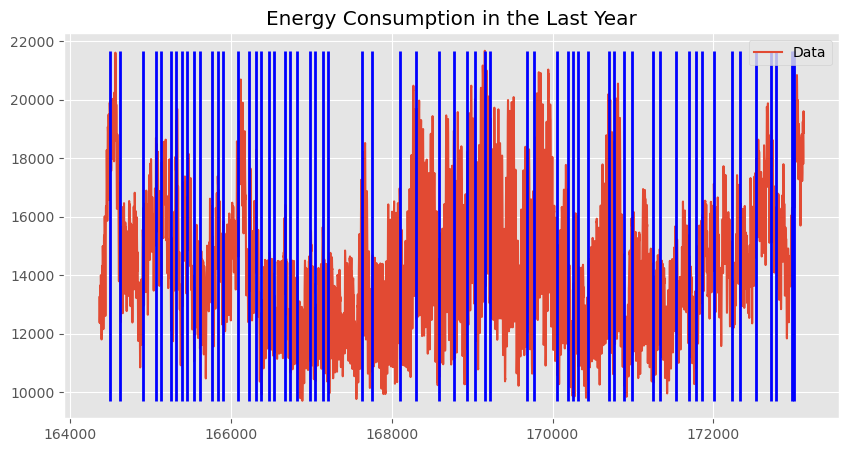

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(last_year_energy, label='Data')
#ax.plot(drifts, last_year_energy[drifts], 'ro', label='Change detected')
ax.vlines(drifts, ymin=min(last_year_energy), ymax=max(last_year_energy), colors='b', linewidth=2)

ax.legend()
ax.set_title('Energy Consumption in the Last Year')

#plt.legend()
plt.show()

## 2.2. Last year (PageHinkley)

PageHinkley is a change detection algorithm that is designed to detect abrupt changes in the mean of the data stream. It uses a cumulative sum to detect abrupt changes in the mean of the data stream.

The PageHinkley algorithm was selected because of its ability to detect abrupt changes in the mean of the data stream.

In [ ]:
drift_detector = drift.PageHinkley()
drifts = []


print(last_year_energy.index[0])

first_idx = last_year_energy.index[0]

for i, val in enumerate(last_year_energy):
    drift_detector.update(val)   # Data is processed one sample at a time
    if drift_detector.drift_detected:
        # The drift detector indicates after each sample if there is a drift in the data
        print(f'Change detected at index {i+first_idx}')
        drifts.append(i+first_idx)
        #drift_detector.reset()   # As a best practice, we reset the detector

164366

Change detected at index 164395

Change detected at index 164425

Change detected at index 164455

Change detected at index 164485

Change detected at index 164515

Change detected at index 164545

Change detected at index 164575

Change detected at index 164605

Change detected at index 164635

Change detected at index 164665

Change detected at index 164695

Change detected at index 164725

Change detected at index 164755

Change detected at index 164785

Change detected at index 164815

Change detected at index 164845

Change detected at index 164875

Change detected at index 164905

Change detected at index 164935

Change detected at index 164965

Change detected at index 164995

Change detected at index 165025

Change detected at index 165055

Change detected at index 165085

Change detected at index 165115

Change detected at index 165145

Change detected at index 165175

Change detected at index 165205

Change detected at index 165235

Change detected at index 165265

Change detected at index 165295

Change detected at index 165325

Change detected at index 165355

Change detected at index 165385

Change detected at index 165415

Change detected at index 165445

Change detected at index 165475

Change detected at index 165505

Change detected at index 165535

Change detected at index 165565

Change detected at index 165595

Change detected at index 165625

Change detected at index 165655

Change detected at index 165685

Change detected at index 165715

Change detected at index 165745

Change detected at index 165775

Change detected at index 165805

Change detected at index 165835

Change detected at index 165865

Change detected at index 165895

Change detected at index 165925

Change detected at index 165955

Change detected at index 165985

Change detected at index 166015

Change detected at index 166045

Change detected at index 166075

Change detected at index 166105

Change detected at index 166135

Change detected at index 166165

Change detected at index 166195

Change detected at index 166225

Change detected at index 166255

Change detected at index 166285

Change detected at index 166315

Change detected at index 166345

Change detected at index 166375

Change detected at index 166405

Change detected at index 166435

Change detected at index 166465

Change detected at index 166495

Change detected at index 166525

Change detected at index 166555

Change detected at index 166585

Change detected at index 166615

Change detected at index 166645

Change detected at index 166675

Change detected at index 166705

Change detected at index 166735

Change detected at index 166765

Change detected at index 166795

Change detected at index 166825

Change detected at index 166855

Change detected at index 166885

Change detected at index 166915

Change detected at index 166945

Change detected at index 166975

Change detected at index 167005

Change detected at index 167035

Change detected at index 167065

Change detected at index 167095

Change detected at index 167125

Change detected at index 167155

Change detected at index 167185

Change detected at index 167215

Change detected at index 167245

Change detected at index 167275

Change detected at index 167305

Change detected at index 167335

Change detected at index 167365

Change detected at index 167395

Change detected at index 167425

Change detected at index 167455

Change detected at index 167485

Change detected at index 167515

Change detected at index 167545

Change detected at index 167575

Change detected at index 167605

Change detected at index 167635

Change detected at index 167665

Change detected at index 167695

Change detected at index 167725

Change detected at index 167755

Change detected at index 167785

Change detected at index 167815

Change detected at index 167845

Change detected at index 167875

Change detected at index 167905

Change detected at index 167935

Change detected at index 167965

Change detected at index 167995

Change detected at index 168025

Change detected at index 168055

Change detected at index 168085

Change detected at index 168115

Change detected at index 168145

Change detected at index 168175

Change detected at index 168205

Change detected at index 168235

Change detected at index 168265

Change detected at index 168295

Change detected at index 168325

Change detected at index 168355

Change detected at index 168385

Change detected at index 168415

Change detected at index 168445

Change detected at index 168475

Change detected at index 168505

Change detected at index 168535

Change detected at index 168565

Change detected at index 168595

Change detected at index 168625

Change detected at index 168655

Change detected at index 168685

Change detected at index 168715

Change detected at index 168745

Change detected at index 168775

Change detected at index 168805

Change detected at index 168835

Change detected at index 168865

Change detected at index 168895

Change detected at index 168925

Change detected at index 168955

Change detected at index 168985

Change detected at index 169015

Change detected at index 169045

Change detected at index 169075

Change detected at index 169105

Change detected at index 169135

Change detected at index 169165

Change detected at index 169195

Change detected at index 169225

Change detected at index 169255

Change detected at index 169285

Change detected at index 169315

Change detected at index 169345

Change detected at index 169375

Change detected at index 169405

Change detected at index 169435

Change detected at index 169465

Change detected at index 169495

Change detected at index 169525

Change detected at index 169555

Change detected at index 169585

Change detected at index 169615

Change detected at index 169645

Change detected at index 169675

Change detected at index 169705

Change detected at index 169735

Change detected at index 169765

Change detected at index 169795

Change detected at index 169825

Change detected at index 169855

Change detected at index 169885

Change detected at index 169915

Change detected at index 169945

Change detected at index 169975

Change detected at index 170005

Change detected at index 170035

Change detected at index 170065

Change detected at index 170095

Change detected at index 170125

Change detected at index 170155

Change detected at index 170185

Change detected at index 170215

Change detected at index 170245

Change detected at index 170275

Change detected at index 170305

Change detected at index 170335

Change detected at index 170365

Change detected at index 170395

Change detected at index 170425

Change detected at index 170455

Change detected at index 170485

Change detected at index 170515

Change detected at index 170545

Change detected at index 170575

Change detected at index 170605

Change detected at index 170635

Change detected at index 170665

Change detected at index 170695

Change detected at index 170725

Change detected at index 170755

Change detected at index 170785

Change detected at index 170815

Change detected at index 170845

Change detected at index 170875

Change detected at index 170905

Change detected at index 170935

Change detected at index 170965

Change detected at index 170995

Change detected at index 171025

Change detected at index 171055

Change detected at index 171085

Change detected at index 171115

Change detected at index 171145

Change detected at index 171175

Change detected at index 171205

Change detected at index 171235

Change detected at index 171265

Change detected at index 171295

Change detected at index 171325

Change detected at index 171355

Change detected at index 171385

Change detected at index 171415

Change detected at index 171445

Change detected at index 171475

Change detected at index 171505

Change detected at index 171535

Change detected at index 171565

Change detected at index 171595

Change detected at index 171625

Change detected at index 171655

Change detected at index 171685

Change detected at index 171715

Change detected at index 171745

Change detected at index 171775

Change detected at index 171805

Change detected at index 171835

Change detected at index 171865

Change detected at index 171895

Change detected at index 171925

Change detected at index 171955

Change detected at index 171985

Change detected at index 172015

Change detected at index 172045

Change detected at index 172075

Change detected at index 172105

Change detected at index 172135

Change detected at index 172165

Change detected at index 172195

Change detected at index 172225

Change detected at index 172255

Change detected at index 172285

Change detected at index 172315

Change detected at index 172345

Change detected at index 172375

Change detected at index 172405

Change detected at index 172435

Change detected at index 172465

Change detected at index 172495

Change detected at index 172525

Change detected at index 172555

Change detected at index 172585

Change detected at index 172615

Change detected at index 172645

Change detected at index 172675

Change detected at index 172705

Change detected at index 172735

Change detected at index 172765

Change detected at index 172795

Change detected at index 172825

Change detected at index 172855

Change detected at index 172885

Change detected at index 172915

Change detected at index 172945

Change detected at index 172975

Change detected at index 173005

Change detected at index 173035

Change detected at index 173065

Change detected at index 173095

Change detected at index 173125

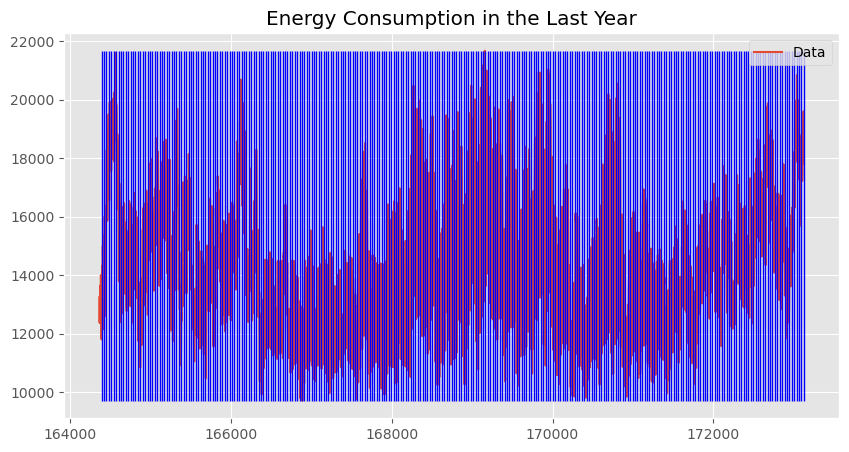

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(last_year_energy, label='Data')
#ax.plot(drifts, last_year_energy[drifts], 'ro', label='Change detected')
ax.vlines(drifts, ymin=min(last_year_energy), ymax=max(last_year_energy), colors='b', linewidth=1)

ax.legend()
ax.set_title('Energy Consumption in the Last Year')

#plt.legend()
plt.show()

As we can see, when using ADWIN and PageHinkley multiple drifts appear, so the dataset is suitable for online learning, since we are trying to detect patterns over time.

# 3. Batch Learning

In a first approach, we will use batch learning models.

To do this, for each model considered, we have divided the dataset into a training set and a test set, allocating 20% ​​of the data to the latter set.

In [ ]:
def load_dataset():
    dataset_copy = df.copy()
    dataset_copy.pop('datetime')
    dataset = dataset_copy.loc[:, dataset_copy.columns != 'AEP']
    target = dataset_copy['AEP']
    dataset = stream.iter_pandas(dataset, target)
    return dataset

def load_batch_data():
    dataset_copy = df.copy()
    dataset_copy.pop('datetime')
    dataset = dataset_copy.loc[:, dataset_copy.columns != 'AEP']
    target = dataset_copy['AEP']
    return dataset, target

In the cell below we can see an example of what a sample of the model would look like, where you can see the created features mentioned in the corresponding section.

In [ ]:
dataset = load_dataset()
for xi, yi in dataset:
    print(xi, yi)
    break

{
    'year': 2004.0,
    'month': 10.0,
    'day': 1.0,
    'hour': 1.0,
    'hour_sin': 0.25881904510252074,
    'hour_cos': 0.9659258262890683,
    'day_sin': 0.20129852008866006,
    'day_cos': 0.9795299412524945,
    'month_sin': 0.4301873756029155,
    'month_cos': 0.9027396201961427,
    'season': 4.0,
    'day_of_week': 4.0,
    'is_weekend': 0.0
}
12379.0

## 3.1. KNN Regressor

The first model considered is a KNN regressor with k=5. As previously mentioned, 20% of the data has been allocated to the test set, using it later to evaluate the model's predictions calculating the mean absolute error, which is the metric selected to evaluate the model's performance. This metric has been selected to be able to see the error of the prediction with respect to the actual value (target) and because it is more interpretable. In addition, 10-fold cross-validation has been applied, therefore, the MAE for each of the folds was calculated and then the averaged was considered.

This process, separating train and test sets and using 10-fold cross-validation, is the one followed for all the batch learning models that are going to be presented in this notebook.

In [ ]:
dataset = load_dataset()
X, y = load_batch_data()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = KNeighborsRegressor()
model.fit(X_train, y_train)

KNeighborsRegressor()

In [ ]:
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
mae_scores = -scores
print('MAE scores:', mae_scores)
print('Mean MAE:', np.mean(mae_scores))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set using MAE
knn_batch = mean_absolute_error(y_test, y_pred)
print('Test MAE:', knn_batch)

MAE scores: [1210.74683377 1322.29511873 1540.67323549 1474.7401006  1255.92171188
 1241.24469366 1268.83570545 1312.76538303 1496.49641296 1258.80260576]

Mean MAE: 1338.252180133685

Test MAE: 707.6287775716347

## 3.2. Linear Regression

Next, we have considered a linear regression model with a learning rate of 0.01. We have also added to the pipeline a zero-mean normalization of the data by removing the mean and scaling to unit variance.

In [ ]:
dataset = load_dataset()
X, y = load_batch_data()

# Define the steps of the model
model = pipeline.Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('lin_reg', linear_model.LinearRegression())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('lin_reg', LinearRegression())])

In [ ]:
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
mae_scores = -scores
print('MAE scores:', mae_scores)
print('Mean MAE:', np.mean(mae_scores))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set using MAE
lin_batch = mean_absolute_error(y_test, y_pred)
print('Test MAE:', lin_batch)

MAE scores: [1760.89155364 1585.1939655  1666.71354655 1656.8797265  1767.2797079
 1458.94226412 1591.98548269 1565.99888228 1797.41226099 1549.35948622]

Mean MAE: 1640.0656876406888

Test MAE: 1609.956541724155

## 3.3. Decission Tree Regressor

Finally, we have used a decision tree regressor, again previously applying zero-mean normalization to the data.

In [ ]:
dataset = load_dataset()
X, y = load_batch_data()

# Define the steps of the model
model = pipeline.Pipeline([
    ('scale', preprocessing.StandardScaler()),
    ('dt', DecisionTreeRegressor())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()), ('dt', DecisionTreeRegressor())])

In [ ]:
scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_absolute_error')
mae_scores = -scores
print('MAE scores:', mae_scores)
print('Mean MAE:', np.mean(mae_scores))

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model on the test set using MAE
dt = mean_absolute_error(y_test, y_pred)
print('Test MAE:', dt)

MAE scores: [1381.25667876 1336.90014842 1593.58261873 1589.16764245 1423.27616063
 1356.51579121 1333.23930073 1323.63453451 1566.16723015 1394.21093428]

Mean MAE: 1429.7951039874174

Test MAE: 451.5203050917337

As we can see in the results, the KNN regressor presents the best MAE average, followed by the decision tree regressor, which also presents the lowest error for the test evaluation. The linear regression model seems the worst of the three.

# 4. Stream Learning

Let us now approach the problem from the point of view of stream learning.

In this case, a test set has not been separated since it is not necessary; the model uses the entire dataset both to train and to evaluate its performance. This is because the model is updated as new data arrives, which is the advantage of using stream models, that they adapt to possible changes over time without the need to retrain the model from scratch.

## 4.1. KNN Regressor

The first model considered is a KNN regressor with k=5 and a window size of 1000. One approach has been run normalizing the data and another without. As we can see in the results, the error obtained is practically the same for both cases, therefore this comparison is not very relevant.

### 4.1.1. KNN Regressor without normalization

In [ ]:
dataset = load_dataset()

model = neighbors.KNNRegressor()
knn_stream = river_metrics.MAE()

for sample, target in dataset:
    prediction = model.predict_one(sample)
    knn_stream.update(target, prediction)
    model.learn_one(sample, target)

print(knn_stream)

MAE: 737.461242

### 4.1.1. KNN Regressor with normalization

In [ ]:
dataset = load_dataset()

model = ( river_preprocessing.Normalizer() |
         neighbors.KNNRegressor()
)
metric = river_metrics.MAE()

for sample, target in dataset:
    prediction = model.predict_one(sample)
    metric.update(target, prediction)
    model.learn_one(sample, target)

print(metric)

MAE: 737.338002

## 4.2. Linear Regression

### 4.2.1. Linear regression without normalization

First, we consider a linear regression model to approach the problem. However, as can be seen in the output below, the error obtained is quite large, considerably higher than those obtained so far. For this reason, it has also been considered adding normalization to the pipeline in order to improve the performance of the model (see 4.2.2.).

In [ ]:
dataset = load_dataset()

model = river_linear_model.LinearRegression()
metric = river_metrics.MAE()

for sample, target in dataset:
    prediction = model.predict_one(sample)
    metric.update(target, prediction)
    model.learn_one(sample, target)

print(metric)

MAE: 20,225,948,483,387,692.

### 4.2.2. Linear regression with normalization

Normalizing the data effectively improves the quality of the predictions made by the model. This can be attributed to the fact that the model is very sensitive to the data, giving for example too much weight to the 'year' input when receiving a value of 2000 when in reality it is one of the less relevant features.

In [ ]:
dataset = load_dataset()

model = (
    river_preprocessing.Normalizer() |
    river_linear_model.LinearRegression()
)

lin_stream = river_metrics.MAE()

for sample, target in dataset:
    prediction = model.predict_one(sample)
    lin_stream.update(target, prediction)
    model.learn_one(sample, target)

print(lin_stream)

MAE: 1,484.070427

## 4.3. Hoeffding Tree Regressor

Finally, we have used a Hoeffding tree regressor with a grace period of 100.

In [ ]:
dataset = load_dataset()

model = (
    river_preprocessing.StandardScaler() |
    tree.HoeffdingTreeRegressor(
        grace_period=100,
        model_selector_decay=0.9
    )
)

hoeff = river_metrics.MAE()
evaluate.progressive_val_score(dataset, model, hoeff)

MAE: 1,678.43943

In this case, the KNN regressor presents by far the best results. Although the linear regressor seemed the worst of all the models considered, when applying normalization we obtained an error similar to that of the Hoeffding tree, even better.

# 5. Conclusions

In the cell below you can see a graph that represents the absolute mean error obtained for each of the models, both batch and stream learning.

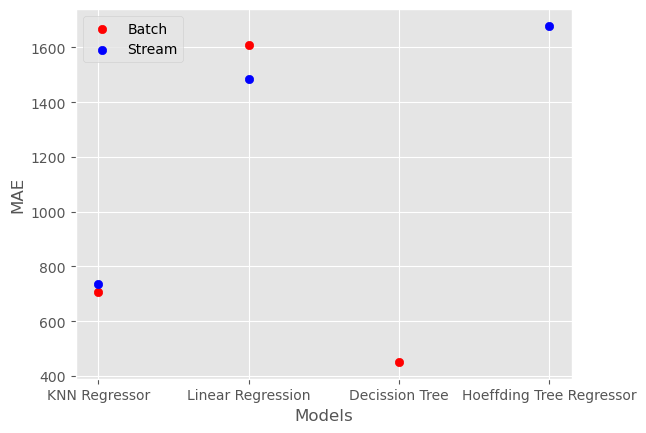

In [ ]:
x1 = ['KNN Regressor', 'Linear Regression', 'Decission Tree']
y1 = [707.62, 1609.95, 451.52]
x2 = ['KNN Regressor', 'Linear Regression', 'Hoeffding Tree Regressor']
y2 = [737.46, 1484.07, 1678.43]
plt.scatter(x1, y1, marker='o', color='red', label='Batch')
plt.scatter(x2, y2, marker='o', color='blue', label='Stream')
plt.xlabel('Models')
plt.ylabel('MAE')
plt.legend()
plt.show()

In general, we have been able to see the advantage of stream learning, since it allows us to update the model as new data arrives without the need to retrain the model from scratch.
However, for this problem, batch learning models have been able to give us better results.

As you could see in the data preprocessing section, in the [hourly energy distribution figure](#hour_dist), there are no significant changes between hours. The changes in energy consumption are rather gradual throughout the day, except for the jump in consumption that exists between 6-7 or 7-8 in the morning, the rest of the day presents more uniform consumption. It is possible that for this reason the models are not capable of predicting consumption for this period of time. However, as an idea for future work, considering larger time frames (such as weeks or months) could lead to an improvement in the performance of the models.

Also, by defining a larger window size, so that the model stores more of the last observed samples (more memory), it is possible that the predictions would be more accurate and therefore the model error would be less.